# Financial Market Analysis using Recurrent Neural Network

* Ref: Fabrice Daniel, Financial Time Series Data Processing for Machine Learning, arXiv:1907.03010
* Financial data clearly has trends, meaning that it is not a stationary time series. To test for stationarity two criterions are Augmented Dickey-Fuller test (ADF) and pvalue. 
* Some methods to make it staionary is differencing using df['Open'].diff().fillna(0.0), or to compute the daily return which is df['DailyReturn'] = df['Close'] - df['Open']. 
* Note that differencing is identical to return if nobody trades after market. 
* To train a time series data, typically one creates time windows as inputs, for instance a time window of 20 consecutive days. (This is the "look back period" for forecasting)
* Specially, build a training set S consisting of series $\hat{X}=\{X_0,X_1,\dots,X_{K-1}\}$, where $X_t=\{x_{t-n},\dots,x_{t-1}\}$, and prediction as $\hat{Y}=\{y_0,y_1,\dots,y_{K-1}\}$ where $y_t=\{x_{t}\}$.
* Note that this is a overlapping window of time series. As a result, the train/validation/test set split must also be chronological.
* Identify training objectives. This could be many. The simplest is the mean square error metric, which measures how close is the predicted price to the actual price. 
* Next we can look at various classifiers, such as the closing price at t is greater than the closing price at t-5 (i.e., predict a five day trend.). This converts the regression model to a classification problem. 
* Next we look at multi-day forecasting. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
%matplotlib inline

                               Open      High       Low     Close      Volume  \
Date                                                                            
1986-03-13 00:00:00-05:00  0.054693  0.062736  0.054693  0.060055  1031788800   
1986-03-14 00:00:00-05:00  0.060055  0.063272  0.060055  0.062199   308160000   
1986-03-17 00:00:00-05:00  0.062199  0.063808  0.062199  0.063272   133171200   
1986-03-18 00:00:00-05:00  0.063272  0.063808  0.061127  0.061663    67766400   

                           Dividends  Stock Splits  
Date                                                
1986-03-13 00:00:00-05:00        0.0           0.0  
1986-03-14 00:00:00-05:00        0.0           0.0  
1986-03-17 00:00:00-05:00        0.0           0.0  
1986-03-18 00:00:00-05:00        0.0           0.0  


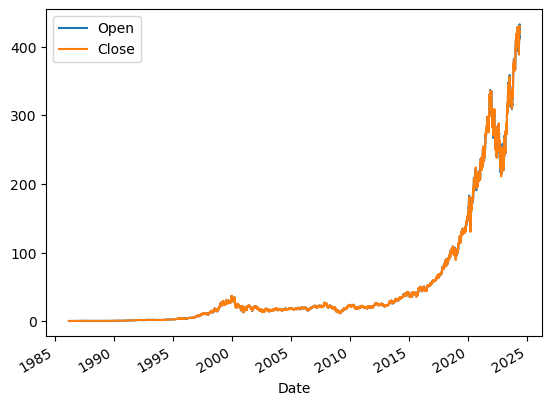

In [2]:
# Yahoo Finance has a nice API
import yfinance as yahooFinance
# GetInformation = yahooFinance.Ticker("^IXIC")
GetInformation = yahooFinance.Ticker("MSFT")
df = GetInformation.history(period="max")
print(df.head(4))
df.plot(y=['Open','Close'])
plt.show()

# Create time windows of size n_window, and multiday forecasting n_forecast 

In [3]:
def create_time_windows(df, n_window ,n_forecast, scale=True ): 
    '''
        This creates a rolling time window (X,y) from the Pandas DataFrame df, and store it in a numpy array of size (nsamples, n_window/n_forecast, nfeatures)
        n_features referr to open/close/volume etc, while also going through a min-max scaler from -1 to 1 for all time windows
    '''
    N, N_features = len(df), len(list(df))
    X, y, scaler = [], [], []
    for i in range(n_window,N-n_forecast):
        tmp = df.iloc[(i-n_window):(i+n_forecast)].to_numpy()
        if scale:
            sc = MinMaxScaler(feature_range=(0,1))
            tmp = sc.fit_transform(tmp)
            scaler.append(sc)
        X.append(tmp[:n_window,...])
        y.append(tmp[n_window:,...])

    # for i in range(N):
    #     if (i+1) * (n_window+n_forecast) <= N:
    #         tmp = df.iloc[(i * (n_window+n_forecast)):((i+1)*(n_window+n_forecast))].to_numpy()
    #         tmp = sc.fit_transform(tmp)
    #         X.append(tmp[:n_window,...])
    #         y.append(tmp[n_window:,...])
        
    return np.array(X), np.array(y), scaler

df1 = pd.DataFrame({'Open':df['Open']})

In [5]:
def plot_regression_results(X,y,model=0,mode='test'):
  fig, ax = plt.subplots(4,4,figsize=(8,6),sharex=True,sharey=True)
  for r in range(4):
    for c in range(4):
        idx = np.random.randint(X.shape[0])
        ax[r,c].plot(range(X.shape[1]),X[idx,:,0],"b-",label='train')
        ax[r,c].plot(range(X.shape[1],X.shape[1]+y.shape[1]),y[idx,:,0],"r-^",label='actual',ms=3)
        if model != 0:
            val = model(X[idx:(idx+1),:,:1])
            ax[r,c].plot(range(X.shape[1],X.shape[1]+y.shape[1]),val[0],"g-x",label='pred.',ms=3)
        if r ==0 and c ==0:
          ax[r,c].legend(fontsize=9)
  fig.suptitle(mode)
  plt.tight_layout()
  plt.show()
  plt.close()

# Feature scaling but inverse transform to original data when plotting the predictions

In [14]:
n_window, n_forecast = 8*5, 1*1
X, y, scaler = create_time_windows(df1, n_window = n_window, n_forecast = n_forecast)
Nsamples = X.shape[0]
Ntrain = int(Nsamples * 0.8) 
Xtrain, ytrain = X[:Ntrain,...], y[:Ntrain,...]
Xtest, ytest = X[Ntrain:,...], y[Ntrain:,...]

nfeatures = 1 # only use first nfeature columns for training and prediction
model2= keras.Sequential([keras.Input(shape=(n_window,nfeatures)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(64,activation="relu"),
                          keras.layers.Dropout(0.2),
                          keras.layers.Dense(64,activation="relu"),
                          keras.layers.Dropout(0.2),
                          keras.layers.Dense(1)])
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss='MSE')
ntrain = int(Xtrain.shape[0]*0.8)
history = model2.fit(Xtrain[:ntrain,:,:nfeatures],ytrain[:ntrain,:,0], batch_size= 32,
                     epochs = 100,validation_data=(Xtrain[ntrain:,:,:nfeatures],ytrain[ntrain:,:,0]))

Epoch 1/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 892us/step - loss: 0.0892 - val_loss: 0.0274
Epoch 2/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - loss: 0.0361 - val_loss: 0.0261
Epoch 3/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 0.0300 - val_loss: 0.0251
Epoch 4/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 0.0270 - val_loss: 0.0204
Epoch 5/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 0.0251 - val_loss: 0.0231
Epoch 6/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 0.0230 - val_loss: 0.0258
Epoch 7/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 0.0226 - val_loss: 0.0207
Epoch 8/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 0.0211 - val_loss: 0.0210
Epoch 9/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 0.0212 - val_loss: 0.0207
Epoch 10/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 0.0199 - val_loss: 0.0190
Epoch 11/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 0.0188 - val_loss: 0.0201
Epoch 12/100
192/19

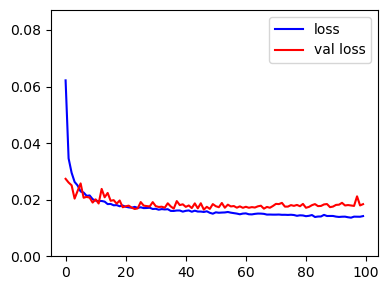

In [15]:
fig = plt.figure(figsize=(4,3))
plt.plot(history.history['loss'],'b-',label='loss')
plt.plot(history.history['val_loss'],'r-',label='val loss')
plt.ylim([0,1.4*max(history.history['loss'])])
# plt.yscale('log')
plt.tight_layout()
plt.legend()
plt.show()
plt.close()

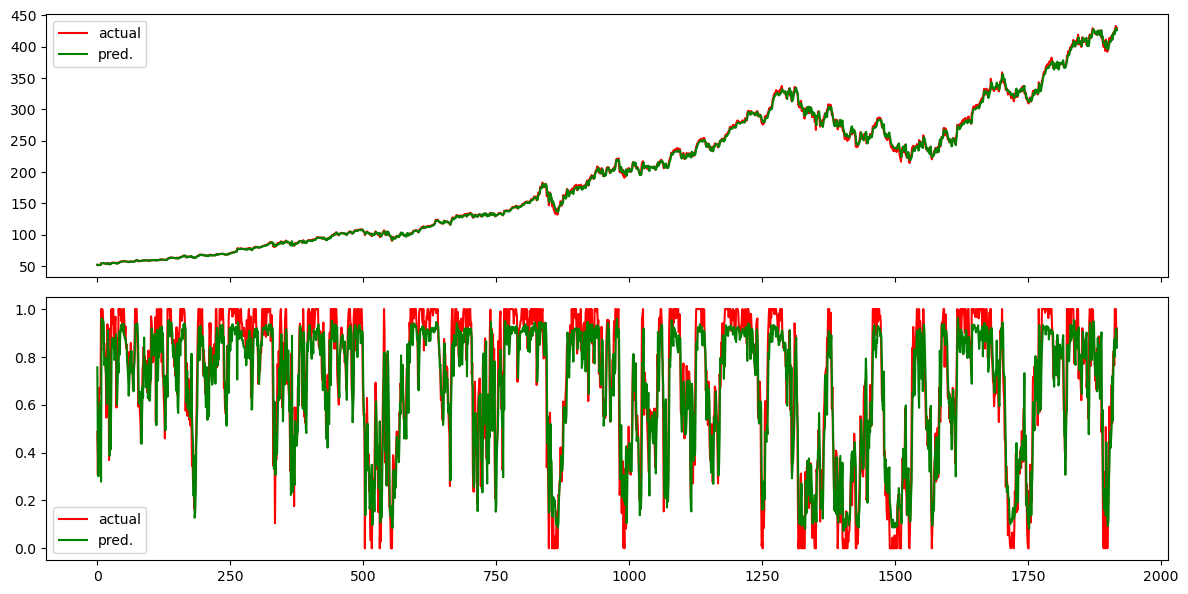

In [16]:
# plot predictions based on model 2
def plot_forecast(X,y,sc,model):
    ypred = model(X[:,:,:1]).numpy().reshape(-1,1,1)
    yactual = y.copy()

    fig,ax = plt.subplots(2,1,figsize=(12,6),sharex=True)
    ax[1].plot(yactual[:,0,0],"r-",label="actual")
    ax[1].plot(ypred[:,0,0],"g-",label="pred.")
    ax[1].legend()
    
    # revert to original form
    for i in range(ypred.shape[0]):
        ypred[i,:,:] = sc[i].inverse_transform(ypred[i,:,:])
        yactual[i,:,:] = sc[i].inverse_transform(yactual[i,:,:])
    
    ax[0].plot(yactual[:,0,0],"r-",label="actual")
    ax[0].plot(ypred[:,0,0],"g-",label="pred.")
    ax[0].legend()

    plt.tight_layout()
    plt.show()
    plt.close(fig)

plot_forecast(Xtest,ytest,scaler[Xtrain.shape[0]:],model2)
# plot_forecast(X,y,scaler,model2)

# A Word on LSTM versus Statistical Model
- At inference, the aforedefined RNN is a deterministic model, namely, for a given set of weights, the chain $ x_0 \rightarrow x_1 \rightarrow \dots x_{t-1}\rightarrow x_t $ is deterministic 
- 